In [3]:
from math import pi
import time
import torch
from tqdm import tqdm
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
from torch.utils.tensorboard import writer, SummaryWriter
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt

from train_compare import Trainer
from datasets.datasets import *
from models.wgangp import Generator, Critic

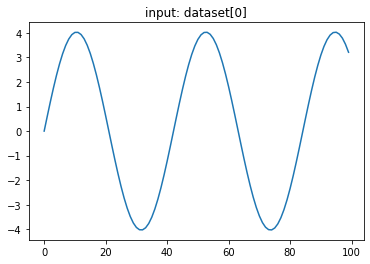

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

CUDA Device used:  cuda
Training is about to start...
data (200, 100)


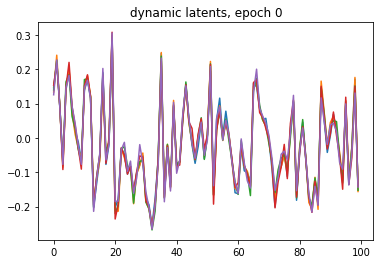

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


In [4]:
args = {}
args['dataset'] = 'sines' #sines, arma, diy_sines
args['log_name'] = 'disect'+'_{:.6f}'.format(time.time())
args['epochs'] = 1 #15000
args['lookback'] = 1
args['batches'] = 16
args['checkpoint_path'] = None
args['store_every'] = 500
args['print_every'] = 250
args['sample_count'] = 5

# Create Dataloader
if args['dataset'] == 'sines':
    dataset = Sines(frequency_range=[0, 2 * pi], amplitude_range=[0, 2 * pi], seed=42, n_series=200)
elif args['dataset'] == 'diy':
    dataset = Load('train_sin25_100', 1)
else:
    dataset = ARMA((0.7, ), (0.2, ))
    
# Instantiate Generator and Critic + initialize weights
g = Generator(input_size=dataset.dataset.shape[1], output_size=dataset.dataset.shape[1])

g_opt = torch.optim.RMSprop(g.parameters(), lr=0.00005)#torch.optim.Adam(g.parameters(), lr=0.00005)
d = Critic(features=dataset.dataset.shape[0])

d_opt = torch.optim.RMSprop(d.parameters(), lr=0.00005)
dataloader = DataLoader(dataset, batch_size=args['batches'])

plt.plot(dataset.dataset[0])
plt.title('input: dataset[0]')
plt.show()
# Instantiate Trainer
trainer = Trainer(g, d, g_opt, d_opt, dataset, print_every=args['print_every'], sample_count=args['sample_count'])
# Train model
print('Training is about to start...')
# Instantiate Tensorboard writer
tb_logdir = os.path.join('..', 'tensorboard', args['log_name'])

print('data', dataset.dataset.shape)
trainer.train(dataloader, epochs=args['epochs'], plot_training_samples=True, checkpoint=args['checkpoint_path'])

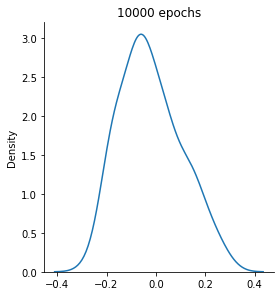

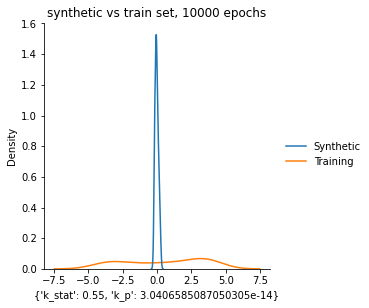

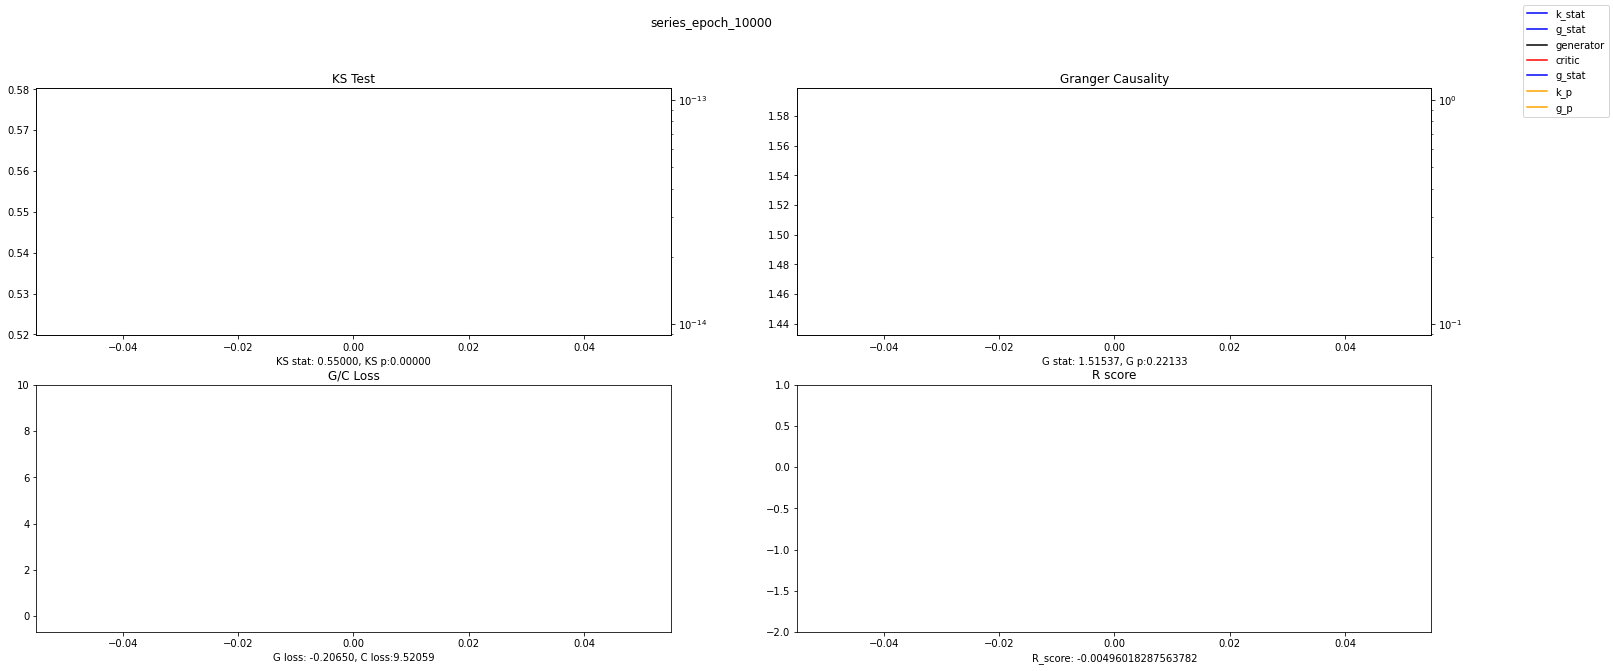

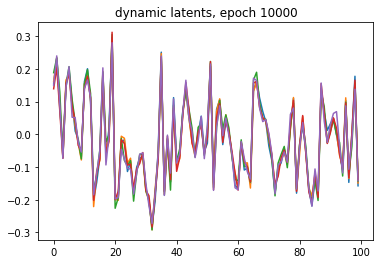

In [5]:
trainer.validate(10000, (200,100))

In [18]:
print(list(enumerate(dataloader))[0][1].shape)
# i, data = list(enumerate(dataloader))

from torchinfo import summary
summary(d , input_size=(16, 100))

torch.Size([16, 100])


Layer (type:depth-idx)                   Output Shape              Param #
Critic                                   --                        --
├─Sequential: 1-1                        [16, 800]                 --
│    └─AddDimension: 2-1                 [16, 1, 100]              --
│    └─Conv1d: 2-2                       [16, 32, 100]             128
│    └─LeakyReLU: 2-3                    [16, 32, 100]             --
│    └─MaxPool1d: 2-4                    [16, 32, 50]              --
│    └─Conv1d: 2-5                       [16, 32, 50]              3,104
│    └─LeakyReLU: 2-6                    [16, 32, 50]              --
│    └─MaxPool1d: 2-7                    [16, 32, 25]              --
│    └─Conv1d: 2-8                       [16, 32, 25]              3,104
│    └─LeakyReLU: 2-9                    [16, 32, 25]              --
│    └─Flatten: 2-10                     [16, 800]                 --
├─Sequential: 1-2                        [16, 1]                   --
│    └─L